# Contact Tracing Report

In [1]:
import matplotlib.pyplot as plt
import numpy.random as npr
import seaborn as sns
import household_contact_tracing_dropbox as model
import warnings
from progressbar import ProgressBar
pbar = ProgressBar()
warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

When considering contact tracing for control of an epidemic a first intuition is that for an epidemic with an $R_0$ of say 3, that you need to successfully contact trace 2/3's of individuals.

This intuition, comes from something along the lines of "We start with one infection, who infects 3 people on average. If we find 2 of these 3 people, then we only have 1 missed infection and the total number of active infections remains the same. Therefore, the epidemic is controlled and we should aim for a contact tracing success rate of 2/3 to control the epidemic."

Unfortunately this line of thinking, while intuitive, does not capture the full complexity of the situation. We have assumed that the contact traced infected did not infect anyone before they were contact traced, and failure to consider this will result in exponential growth. In addition, there are many more delays in a contact tracing process.

## COVID Model Assumptions

We model an epidemic spreading through a completely susceptible population, segmented into households.

We assume the incubation period (delay from becoming infected, to displaying symptoms) is distributed:
$$I\sim Gamma(\text{mean } =  4.83, \text{sd} = 2.78)$$

An individual makes contacts at the normal (before social distancing rate). The infectiousness of an individual varies over time, and depends on their incubation period. A percentage of infections will occur before they are symptomatic, and the time of these infections will depend on when they become symptomatic, as the majority of infections occur when symptoms are present.

Following Ferretti et al, (https://science-sciencemag-org.manchester.idm.oclc.org/content/early/2020/03/25/science.abb4218), we model the generation time distribution using a Weibull with mean = 5 and standard deviation of 1.9

$$\text{Generation Times} \sim \text{Weibull(mean = 5, var = 1.9^2)}$$

Each day, an individual makes contacts a number of different individuals, which provide opportunities for the infection to be spread. The number of contacts made are overdispersed, so it is possible for an individual to make a very high number of contacts infrequently. Each contact has a probability of passing on the infection, where the probability is chosen to give rise to the desired generation time distribution. Together, these allow for overdispersed infections, which is important when considering contact tracing.

We model the infection as a branching process of individuals, with a household structure overlaid on top. The household structure benefits the contact tracing process, as all infected individuals in a household are isolated immediately.

$$R_0 = 2.7$$

## Contact Tracing Model Assumptions

Contact tracing has several key components that control it's effectiveness; reporting probability, report delay, success rate and contact tracing delay.

Contact tracing begins, when an infected individual reports their symptoms. However, as many people only experience mild symptoms, some of them will not report their infection and recover naturally. The reporting probability is defined as the probability of an infected reporting their infection and initiating a contact tracing intervention.

We have assumed an optimistic detection rate of 0.2. See work from LHSTM which reports currently we are detecting 3.4% of cases.
https://cmmid.github.io/topics/covid19/severity/global_cfr_estimates.html

$$ \text{Probability of reporting infection} = 0.2$$

Given that a node will report their symptoms, there is a delay from developing the initial symptoms to reporting them. During this time, an individual can still infect and we assume they still make contacts at the usual rate.

Onset to confirmation was mean 6.5 days in the early days of the Wuhan outbreak, reducing to 4.8 with more active surveillance measures (https://science-sciencemag-org.manchester.idm.oclc.org/content/early/2020/03/25/science.abb4218). This agrees with the FF100 data which has a mean of approximately 6. We model reporting delays using the geometric distribution.

We assume there are more active surveillance measures an choose mean reporting delay = 4.8.

$$ \text{Reporting Delay} \sim Geometric(\frac{1}{4.8})$$

Once a node reports their symptoms, they are immediately isolated (which we assume is 100% effective). The contact tracing process begins, and attempts to trace their contacts. It is not always going to be possible to trace a contact, and the number of contacts that will be traced is defined by the success probability.
$$ \text{Assume Contact Tracing Success Probability} = \frac{2}{3}$$

Finally, contact tracing is not an instant process. Conditioning on the event that the edge will be discovered, there is a delay to discovering that edge.
$$\text{Assume Contact Tracing Delay} \sim Geometric(1/2)$$

#### Social Distancing:

We don't yet know how effective social distancing is, or will continue to be.

We have assumed that the number of contact made by individuals is reduced by 50%, will the aim of modelling a post-lockdown scenario.

$$ \text{Assume Daily Contact Reduction} = 50\%$$

## Simulation

The simulation functions considering the outbreak as a branching process. For now, we treat the population as entirely susceptible.

#### Code import & setting up

In [21]:
simulation = model.household_sim_contact_tracing(haz_rate_scale = 0.805,
                                                contact_tracing_success_prob = 2/3,
                                                prob_of_successful_contact_trace_today = 1/3,
                                                overdispersion = 0.36,
                                                infection_reporting_prob = 0.7,
                                                reporting_delay_par = 1/2,
                                                contact_trace = True,
                                                reduce_contacts_by = 0.0) # 0.1 means a person makes 10% less contacts

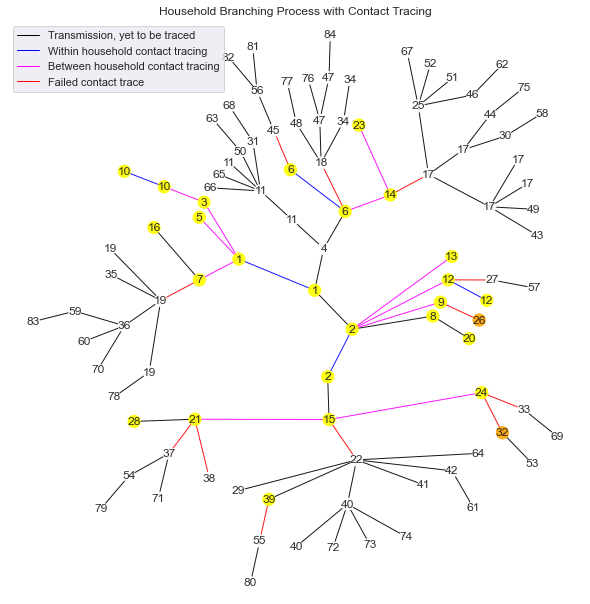

In [25]:
npr.seed(4)
simulation.run_simulation(time_out = 20)
simulation.draw_network()
plt.savefig("BranchingProcess.png")

In [28]:
simulation.house_dict[24]

{'size': 6,
 'time': 14,
 'susceptibles': 5,
 'isolated': True,
 'contact_traced': True,
 'time_until_contact_traced': 16,
 'being_contact_traced_from': 15,
 'generation': 3,
 'infected_by': 15,
 'spread_to': [32, 33],
 'nodes': [32],
 'infected_by_node': 17,
 'within_house_edges': []}

* Yellow means a case has been isolated and displays symptoms
* Orange means a case has been isoalted, but does not yet show symptoms, so has not propagated the contact tracing
* The numbers are the house ID

Running the simulation 1000 times.

Percentage Extinct after 30 days: 21.45%
Remember, this is for a single starting infection
Wall time: 39min 48s


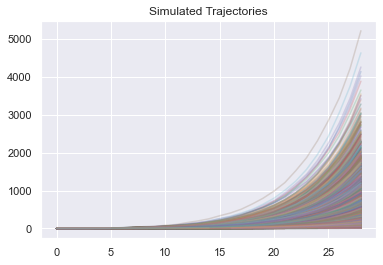

In [41]:
%%time
# Set up the simulation
simulation = model.household_sim_contact_tracing(haz_rate_scale = 0.805,
                                                contact_tracing_success_prob = 2/3,
                                                prob_of_successful_contact_trace_today = 1/3,
                                                overdispersion = 0.36,
                                                infection_reporting_prob = 0.7,
                                                reporting_delay_par = 1/4.8,
                                                contact_trace = True,
                                                reduce_contacts_by = 0.0)

# Code to repeat the simulation and report the output
npr.seed(1)
days_to_simulate = 30
number_of_repeats = 10000
times_went_extinct = 0
for repeat in range(number_of_repeats):
    print(f"repeat: {repeat}/{number_of_repeats}", end = "\r")
    
    simulation.run_simulation(days_to_simulate)
    plt.plot(simulation.total_cases, alpha = 0.25)
    
    if simulation.died_out == True:
        times_went_extinct += 1
plt.title("Simulated Trajectories")
print(f"Percentage Extinct after {days_to_simulate} days: {times_went_extinct*100/number_of_repeats}%")
print("Remember, this is for a single starting infection")

Percentage Extinct after 360 days: 100.0%
Remember, this is for a single starting infection
Wall time: 1min 19s


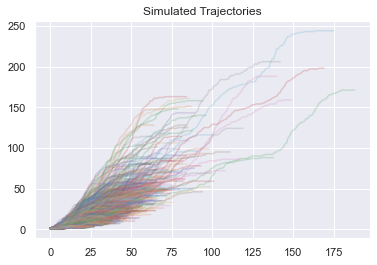

In [38]:
%%time
# Set up the simulation
simulation = model.household_sim_contact_tracing(haz_rate_scale = 0.805,
                                                contact_tracing_success_prob = 2/3,
                                                prob_of_successful_contact_trace_today = 1/3,
                                                overdispersion = 0.36,
                                                infection_reporting_prob = 0.7,
                                                reporting_delay_par = 1/4.8,
                                                contact_trace = True,
                                                reduce_contacts_by = 0.7)

# Code to repeat the simulation and report the output
npr.seed(1)
days_to_simulate = 360
number_of_repeats = 10000
times_went_extinct = 0

extinction_times = []

for repeat in range(number_of_repeats):
    print(f"repeat: {repeat}/{number_of_repeats}", end = "\r")
    
    simulation.run_simulation(days_to_simulate)
    plt.plot(simulation.total_cases, alpha = 0.25)
    
    if simulation.died_out == True:
        times_went_extinct += 1
        extinction_times.append(simulation.time)
plt.title("Simulated Trajectories")
print(f"Percentage Extinct after {days_to_simulate} days: {times_went_extinct*100/number_of_repeats}%")
print("Remember, this is for a single starting infection")

Text(0.5, 1.0, 'Extinction Times')

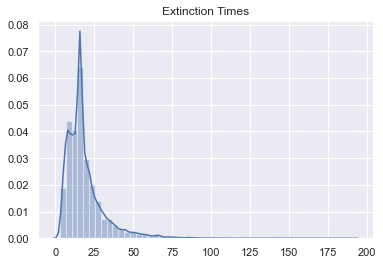

In [39]:
sns.distplot(extinction_times, kde = True)
plt.title("Extinction Times")

## Conclusions
We demonstrate that even with social distancing reducing contacts by 50% and a 2/3 success rate in contact tracing, there is a good chance that a single infection will lead to a second outbreak. It is highly unlikely that a single case will be the starting point. We have not modeled the immune population, assuming that the population is fully susceptible.

If contact tracing based control of the infection is desired, the performance of control tracing efforts must be improved, with 3 main areas:
* Decreasing time from symptom onset to detection
* Higher detection rates, possibly through testing
* Decreasing edge discovery times